# Experiments in Synapse Modeling and Related
We compare different models of a single excitatory synapse, then use one of them to demonstrate a potential model of short-term synaptic depression, the effect where depletion of synaptic vesicles causes temporarily reduced EPSP magnitude.

In [1]:
%matplotlib nbagg
import functools
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy.optimize as spo
import scipy.interpolate as spolate

# Convenience functions in the local directory
from dynamical import hybrid_sim

In [2]:
# Parameters for cortical RS pyramidal neuron taken from Izhikevich (2007)
C, k = 100, 0.7
vr, vt, vp = -60, -40, 35
a, b, c, d = 0.03, -2, -50, 100

Istar = k/4 * (vr - vt - b/k)**2

def jump_map(t, vu):
    return np.array([c,d]) + np.array([0,1]) * vu

def flow_map(I, t, vu):
    v, u = vu
    vdot = (k*(v - vr)*(v - vt) - u + I)/C
    udot = a * (b * (v - vr) - u)
    return np.array([vdot, udot])

def P(t, vu):
    return vu[0] - vp


# These are kind of based on data from a paper, but 
# the results are the same as long as you stay subthreshold 
# and preserve the order of magnitude of tau_syn.
tau_syn = 11.5
I_max = 0.65 * C/tau_syn


### Comparison of Synapse Models
This section compares a few synapse models by simulating the subthreshold oscillations of a postsynaptic cell whose single presynaptic cell is firing action potentials at a fixed rate of 10Hz, or a 100ms interspike interval. Each synapse model is just a different shape for the postsynaptic current (PSC), which has the side effect of creating a different shape for the postsynaptic potential (PSP). I tried exponential decay, the empirically motivated "alpha function", and the Dirac delta. Graphs are below, of course, but the results are as follows.

Apparently there isn't much difference between $\alpha$ functions and exponentials as synapses, as long as you make sure they have the same *area* rather than the same *peak* as I initially tried. (This means making the peak of the alpha function $e$ times smaller, if you actually go through the integration.)

In both cases, both $u$ and $v$ trajectories are very similar except for a slightly larger peak EPSP for exponentials and $u$ not approaching 0 as closely for alpha functions. These are caused by the same phenomenon: although the functions have the same area, the alpha function is spread out a little more. This matters because the synaptic time constant and the leaky integration time constant have similar order of magnitude. If the synaptic time constant were very small, the other functions would behave the same as the simplest synapse function, the Dirac delta.

In [3]:
def sim_with_timed_spikes(spike_time, num_spikes, spike_map,
                          flow_map, jump_map, jump_event, x0):
    touts, xouts, tspike = [], [], []
    for T in range(num_spikes):
        t_range = (T*spike_time, (T+1)*spike_time)
        tout, xout, tev = hybrid_sim(flow_map, jump_map, jump_event, t_range, x0)
        touts.append(tout)
        xouts.append(xout)
        tspike.extend(tev[0])
        x0 = spike_map(tout[-1], xout[-1,:])
    tout = np.hstack(touts)
    xout = np.vstack(xouts)
    return tout, xout, tspike
    
def extend_jump_event(jump_event, ndims):
    "Add ndims NOP dimensions to a jump event."
    @functools.wraps(jump_event)
    def ev(t, XY):
        return jump_event(t, XY[:-ndims])
    return ev
    
def extend_jump_map(jump_map, ndims):
    "Add ndims nonjumping dimensions to a jump map."
    @functools.wraps(jump_map)
    def jump(t, XY):
        X = XY[:-ndims]
        Y = XY[-ndims:]
        return np.hstack([jump_map(t,X), Y])
    return jump


In [4]:
# Typically, in my model, I use these simple exponential synapses.

def flow_exp(t, VUI):
    _, _, I = VUI
    VUIdot = flow_map(I, t, VUI[:2])
    return np.append(VUIdot, -I/tau_syn)

jump_exp = extend_jump_map(jump_map, 1)
ev_exp = extend_jump_event(P, 1)

def spike_exp(t, VUI):
    V, U, I = VUI
    return np.array([V, U, I + I_max])

tout_exp, xout_exp, tspike_exp = sim_with_timed_spikes(100, 5, spike_exp,
                                                      flow_exp, jump_exp, ev_exp,
                                                      [vr, 0, I_max])

In [5]:
# Here, we test the EPSPs of alpha-function synapses in comparison.

def flow_alp(t, VUIJ):
    _, _, I, J = VUIJ
    VUIdot = flow_map(I, t, VUIJ[:2])
    return np.concatenate((VUIdot, 
                           np.array([J, -(I + 2*J)])
                           /tau_syn))

jump_alp = extend_jump_map(jump_map, 2)
ev_alp = extend_jump_event(P, 2)

def spike_alp(t, VUIJ):
    V, U, I, J = VUIJ
    return np.array([V, U, I, J + I_max])

tout_alp, xout_alp, tspike_alp = sim_with_timed_spikes(100, 5, spike_alp,
                                                      flow_alp, jump_alp, ev_alp,
                                                      [vr, 0, 0, I_max])

In [6]:
# An even simpler model: a Dirac delta.

flow_del = functools.partial(flow_map, 0)
jump_del = jump_map
ev_del = P

def spike_del(t, VU):
    V, U = VU
    return np.array([V + I_max / C * tau_syn, U])

tout_del, xout_del, tspike_del = sim_with_timed_spikes(100, 5, spike_del,
                                                      flow_del, jump_del, ev_del,
                                                      [vr, 0])

<IPython.core.display.Javascript object>


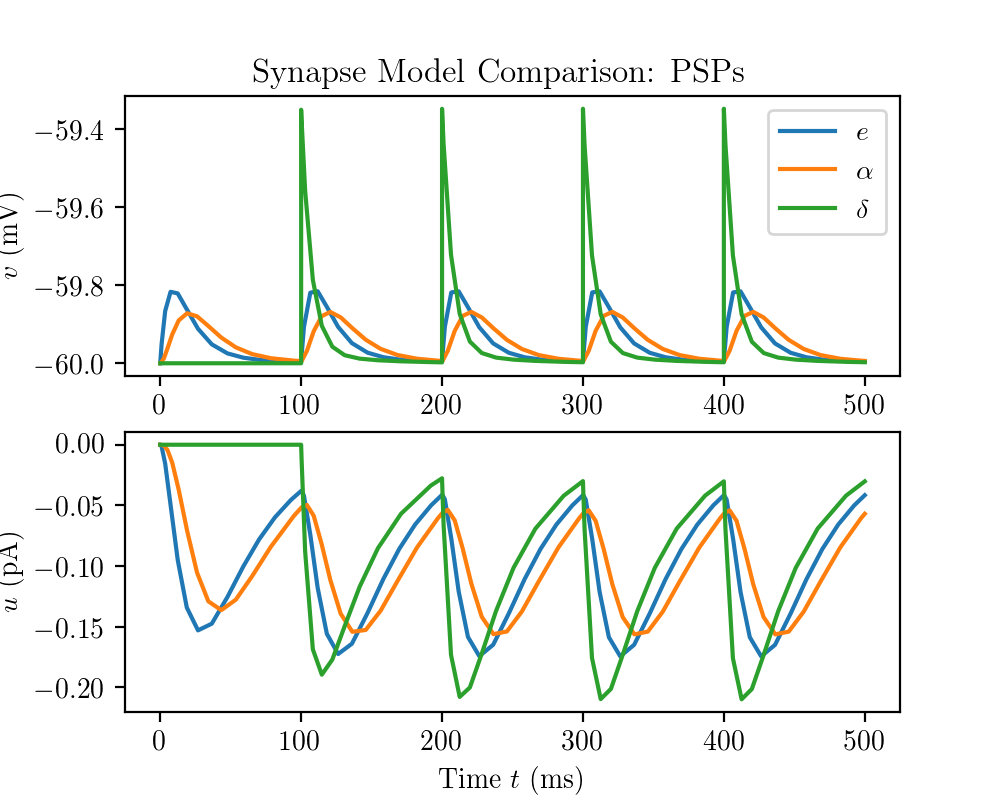

In [7]:
# A comparison of all the results.

plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout_exp[0,:], xout_exp[:,0], label='$e$')
plt.plot(tout_alp[0,:], xout_alp[:,0], label='$\\alpha$')
plt.plot(tout_del[0,:], xout_del[:,0], label='$\\delta$')
plt.legend()
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout_exp[0,:], xout_exp[:,1])
plt.plot(tout_alp[0,:], xout_alp[:,1])
plt.plot(tout_del[0,:], xout_del[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('Synapse Model Comparison: PSPs', y=0.925)


### Adaption vs. Facilitation and Depression
In biological neurons, several different effects cause variation in the response to a constant input. Spike Frequency Adaption (SFA), which is included in the Izhikevich neuron dynamics through the parameter $d$, is when the effective threshold increases each time a neuron fires. 

There are complementary effects of a pulse train on the postsynaptic side, however, which are not yet modeled. Facilitation occurs when subsequent PSPs increase in size (accumulating presynaptic $\text{Ca}^{2+}$ facilitates synaptic vesicle release), and depression is the reverse (caused by a decrease in available vesicles). 

The effect of that cell is modeled as an injected current with synapse-like properties.
I used alpha-function current because the membrane potential is far from the reversal potential of AMPAR and NMDAR, the typical excitatory channels. This is easier to implement, but constitutes another way in which my modeling of inhibitory synapses is currently broken since the GABAAR reversal potential is -70mV, which is close to the resting potential.

The below is *one* possible model of depression, with parameters set such that because of depression a constant input spike train creates only a single output spike. Of course the remainder of the spikes bring the cell close to threshold, and it probably could be induced to fire an AP by a coincident firing by a fairly weak synapse.

In [8]:
PPR = 0.7
D0 = -np.log(PPR) / np.e
tau_depression = 100

I_trig = 300

def flow_dep(t, VUID):
    _, _, I, D = VUID
    VUIDdot = flow_map(I, t, VUID[:2])
    return np.append(VUIDdot, [-I/tau_syn, -D/tau_depression])

def jump_dep(t, VUID):
    _, _, I, D = VUID
    VUIDplus = jump_map(t, VUID[:2])
    return np.append(VUIDplus, VUID[2:])

ev_dep = extend_jump_event(P, 2)

def spike_dep(t, VUID):
    V, U, I, D = VUID
    D += D0
    return np.array([V, U, I + I_trig * np.exp(-D), D])

tout_dep, xout_dep, tspike_dep = sim_with_timed_spikes(100, 5, spike_dep,
                                                      flow_dep, jump_dep, ev_dep,
                                                      [vr, 0, I_trig, 0])

<IPython.core.display.Javascript object>


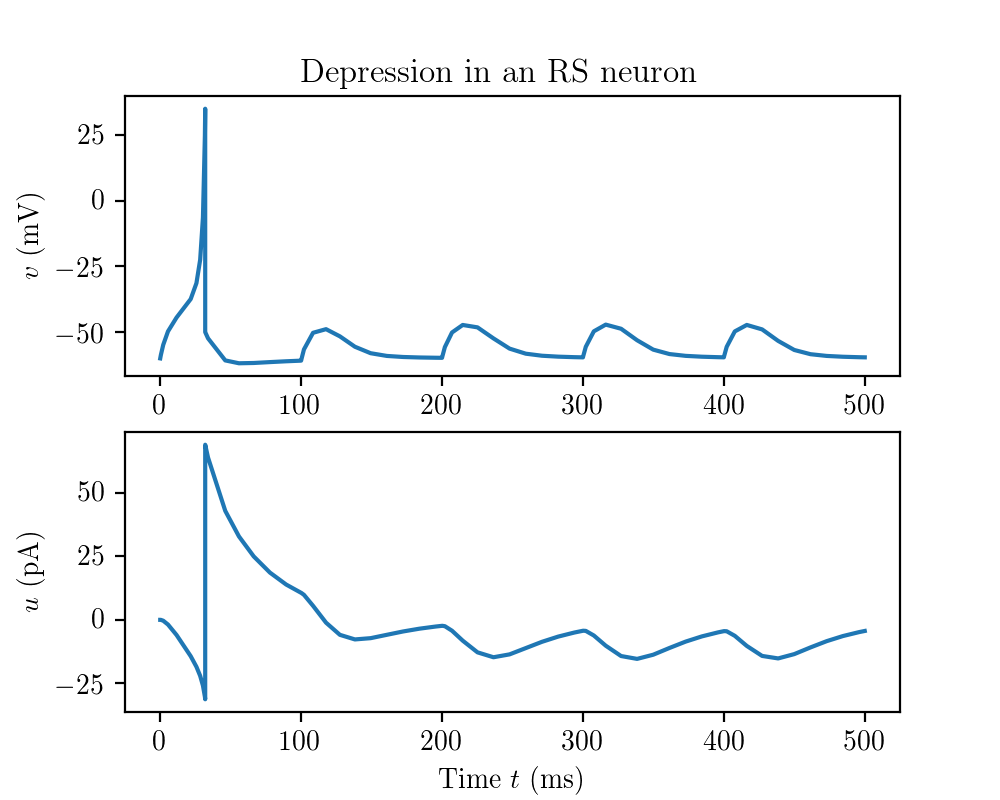

In [9]:
plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout_dep[0,:], xout_dep[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout_dep[0,:], xout_dep[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('Depression in an RS neuron', y=0.925)

# Bibliography

Izhikevich E. M. (2007). _Dynamical Systems in Neuroscience_. MIT press.
> Source of the model of the cortical RS neuron used here.
